In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from utils.helper import set_seed
from matplotlib import pyplot as plt
from utils.xray_plot import draw_pred
import os
import re
import random
from matplotlib import pyplot as plt
import json
import cv2
#import skimage
import numpy as np
from collections import OrderedDict
import torchvision
from inference import *

device = "cuda" if torch.cuda.is_available() else "cpu"
import torch

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Arc
from matplotlib.transforms import Bbox, IdentityTransform, TransformedBbox


class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])

In [7]:
transform_pipeline =  transforms.Compose([
     lambda x: x/255,
                               transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                    ])

def resnet34(outshape, source_domain):
    if source_domain == "ImageNet":
        resnet = models.resnet34(pretrained=True)
    elif not source_domain:
        resnet = models.resnet34(pretrained=False)
    else:
        raise NotImplementedError("Unknown source domain.")
    num_features = resnet.fc.in_features
    resnet.fc = nn.Linear(num_features, outshape)
    return resnet

In [8]:
class XrayModel(nn.Module):
    def __init__(self, backbone):
        super(XrayModel, self).__init__()
        self.resnet = backbone # output size = resnet18_shape

    def forward(self, x):
        x = self.resnet(x)
        return x
    
    
model = XrayModel(resnet34(13, "ImageNet")).to(device)

    # cpu
checkpoint = torch.load("042906-resnet34-3000ep.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

c:\Users\akame\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\akame\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [9]:
# pred = run_inference_xml(model, "LC828.png")
pred = run_inference_xml(model, "1014.postopAxillary.jpg")

In [10]:
import fnmatch

def find_images(directory, patterns=['*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp', '*.tiff']):
    """
    Print all image file names found in the specified directory and its subdirectories.

    Args:
    - directory (str): The path to the directory to search.
    - patterns (list): A list of patterns to match against file names.
    """
    preds = []
    image_names = []
    for root, dirs, files in os.walk(directory):
        for pattern in patterns:
            for filename in fnmatch.filter(files, pattern):
                pred = run_inference_xml(model, os.path.join(root, filename))
                preds.append(pred)
                image_names.append(filename)
    return image_names, preds


In [11]:
# zipped = zip(*find_images("."))

# mapping = {k:v for k,v in zipped}

In [12]:
# list(mapping.keys())[0].split("\\")[-1]

In [13]:
import matplotlib.patches as patches
from PIL import Image
import io

ordered_labels = ['Humeral head fit',
 'Spinoglenoid notch',
 'Anterior lip (glenoid fossa)',
 'Posterior lip (glenoid fossa)',
 'Center (glenoid fossa)',
 'Scapular body']

def draw_pred_tr(y, num_ell=2, num_pts=4) -> None:
    
    colors = iter(['b','lime','r','c','m','gold'])
    labels = iter(ordered_labels)

    # the first 5 used to be ellipse
    ellipses = y[:5]
    points = y[5:]
    # torch auto casts data to floating point numbers
    # to make the behavior of plt.imshow consistent
    # recast the image to int type
    for i in range(num_ell):
        if i == 0: # 'Circle fit to humeral articular surface'
            cx, cy, rx= ellipses[0:3]
            ry = rx
            dx, dy = rx * 2, ry * 2
            plt.gca().add_patch(
            patches.Ellipse(xy=(cx, cy), width=dx, height=dy,fill=False,color=next(colors),label = next(labels)))

        if i == 1: # 'Spinoglenoid notch'
            x, y = ellipses[3:5]
            cur_color = next(colors)

            plt.scatter(x,y,color=cur_color,label = next(labels), s=120, linewidths=0.5)
    

    for k in range(num_pts):
        x, y = points[2*k:2*(k+1)]
        cur_color = next(colors)
        plt.scatter(x,y,color=cur_color,label = next(labels), s=120, linewidths=0.5)



def draw_pred_(y, num_ell=2, num_pts=4) -> None:
    
    colors = iter(['b','lime','r','c','m','gold'])
    labels = iter(ordered_labels)

    # the first 5 used to be ellipse
    ellipses = y[:5]
    points = y[5:]
    # torch auto casts data to floating point numbers
    # to make the behavior of plt.imshow consistent
    # recast the image to int type
    for i in range(num_ell):
        if i == 0: # 'Circle fit to humeral articular surface'
            cur_color = next(colors)
            cx, cy, rx= ellipses[0:3]
            ry = rx
            dx, dy = rx * 2, ry * 2
            plt.gca().add_patch(
            patches.Ellipse(xy=(cx, cy), width=dx, height=dy,fill=False,color=cur_color,label = next(labels) + ": inferred", linestyle="--"))
            
            plt.scatter(cx,cy,color="yellow", s=240, marker="s", facecolors="none")
            plt.scatter(cx,cy,color=cur_color, s=120, marker="X", linewidths=0.5)


        if i == 1: # 'Spinoglenoid notch'
            x, y = ellipses[3:5]

            cur_color = next(colors)
            plt.scatter(x,y,color="yellow", s=240, marker="s", facecolors="none")
            plt.scatter(x,y,color=cur_color,label = next(labels) + ": inferred", s=120, marker="X", linewidths=0.5)
            

    

    for k in range(num_pts):
        x, y = points[2*k:2*(k+1)]
        cur_color = next(colors)
        plt.scatter(x,y,color="yellow", s=240, marker="s", facecolors="none")
        plt.scatter(x,y,color=cur_color,label = next(labels) +": inferred", s=120, marker="X", linewidths=0.5)

    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

def connect(a, b, num_ell=2, num_pts=4):
    colors = iter(['b','lime','r','c','m','gold'])

    # the first 5 used to be ellipse
    ellipses = a[:5]
    points = a[5:]

    ellipses_b = b[:5]
    points_b = b[5:]
    # torch auto casts data to floating point numbers
    # to make the behavior of plt.imshow consistent
    # recast the image to int type
    for i in range(num_ell):
        if i == 0: # 'Circle fit to humeral articular surface'
            cx, cy, rx= ellipses[0:3]
            bx, by, _ = ellipses_b[0:3]
            cur_color = next(colors)
            plt.scatter(cx,cy,color="yellow", s=240, marker="s", facecolors="none")
            plt.scatter([cx],[cy],color=cur_color, linestyle = "--", s=120, marker="o", facecolors="none")
            # plt.scatter(x,y,color=cur_color,label = next(labels) + ": inferred", s=120, marker="X", linewidths=0.5)


            plt.scatter(bx, by, c= cur_color,s=120, marker="o")
            plt.plot(np.linspace(cx, bx,100),np.linspace(cy, by,100), c=cur_color )

        if i == 1: # 'Spinoglenoid notch'
            x, y = ellipses[3:5]
            bx, by= ellipses_b[3:5]
            cur_color = next(colors)
            plt.plot(np.linspace(x, bx,100),np.linspace(y, by,100), c=cur_color )

    for k in range(num_pts):
        x, y = points[2*k:2*(k+1)]
        xb, yb = points_b[2*k:2*(k+1)]
        cur_color = next(colors)
        
        # plt.plot(np.linspace(x, xb,100),np.linspace(y, yb,100), c=cur_color )
        plt.plot(np.linspace(x.item(), xb.item(),100),np.linspace(y.item(), yb.item() ,100), c=cur_color )





ordered_labels = ['Humeral head fit',
 'Spinoglenoid notch',
 'Anterior lip (glenoid fossa)',
 'Posterior lip (glenoid fossa)',
 'Center (glenoid fossa)',
 'Scapular body']

# "LC828.png"
tr = torch.Tensor([537.92, 393.95, 132, 584.61, 581.63, 657.76,469.97,518.58,533.76,603.63,514.43,689.80,585.30])

# PM913-2.png

tr_pm913 =  torch.Tensor([316.42, 276.47, 127, 393.21, 476.72, 459.64, 326.98,335.81,415.91,406.74,382.70, 471.4, 497.8])

# 1014.postopAxillary.jpg

tr_1014pa = torch.Tensor([309.79, 365.78, 144.1, 264.88, 584.89, 181.1, 436.60, 357.5,556.2,255.7,503.7, 169.2,634.7])

In [14]:
((pred - tr_1014pa)**2).mean()

tensor(8.6616)

In [15]:
def calc_eud(pred, tr):
    diff = pred - tr

    hum = np.sqrt(diff[0]** 2+ diff[1]**2)
    hum_r = np.abs(diff[2])

    notch  = np.sqrt(diff[3]** 2+ diff[4]**2)

    alip = np.sqrt(diff[5]** 2+ diff[6]**2)

    plip = np.sqrt(diff[7]** 2+ diff[8]**2)

    clip =np.sqrt(diff[9]** 2+ diff[10]**2)

    sc =np.sqrt(diff[11]** 2+ diff[12]**2)

    return list(map(lambda x: np.round(x.item(),4), [hum, hum_r, notch, alip, plip, clip, sc ]))

In [16]:
pred - tr_1014pa, calc_eud(pred, tr_1014pa)

(tensor([ 2.2465,  2.6578,  1.2749,  5.2337,  0.9930, -2.6245,  0.1530,  1.7873,
          4.3273, -0.7037,  3.2134,  3.5983, -4.2292]),
 [3.4801, 1.2749, 5.3271, 2.629, 4.6819, 3.2896, 5.5528])

In [22]:
def line_intersection(A, B, C, D):
    """
    Find the intersection point of two lines AB and CD.
    A, B, C, D are tuples (x, y) representing the coordinates of the points.
    """
    x1, y1 = A
    x2, y2 = B
    x3, y3 = C
    x4, y4 = D

    # Calculate the determinants
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None  # The lines are parallel or coincident

    # Numerators for the parameter t and u
    t_num = (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)
    u_num = (x1 - x3) * (y1 - y2) - (y1 - y3) * (x1 - x2)

    # Calculate intersection point
    t = t_num / denom
    intersection_x = x1 + t * (x2 - x1)
    intersection_y = y1 + t * (y2 - y1)

    return (intersection_x, intersection_y)

def cal_retroversion(yhat):

    s_x, s_y = yhat[-2], yhat[-1]
    c_x, c_y = yhat[-4], yhat[-3]

    p_x, p_y = yhat[-6], yhat[-5]
    a_x, a_y = yhat[-8], yhat[-7]

    sc_x, sc_y = c_x-s_x, c_y-s_y

    pa_x, pa_y = a_x-p_x, a_y - p_y

    dot_prod = sc_x*pa_x + sc_y*pa_y

    denom = np.sqrt(sc_x**2 + sc_y**2) * np.sqrt(pa_x**2 + pa_y**2)

    angle_cos = dot_prod/denom

    return np.degrees(np.arccos(angle_cos)).item()

def draw_extended_lines(A, B, C=None, D=None, extension_factor=0.3):
    """
    Draw the lines AB and CD extended by a given factor.
    A, B, C, D are tuples (x, y) representing the coordinates of the points.
    extension_factor is the proportion by which to extend the lines.
    """
    def extend_line(A, B, extension_factor):
        x1, y1 = A
        x2, y2 = B

        # Calculate the length of the line
        length = ((x2 - x1)**2 + (y2 - y1)**2)**0.5

        # Calculate the extended points
        ext_x1 = x1 - (x2 - x1) * extension_factor
        ext_y1 = y1 - (y2 - y1) * extension_factor
        ext_x2 = x2 + (x2 - x1) * extension_factor
        ext_y2 = y2 + (y2 - y1) * extension_factor

        return (ext_x1, ext_y1), (ext_x2, ext_y2)

    # Extend lines AB and CD
    A_ext, B_ext = extend_line(A, B, extension_factor)
    if C:
        C_ext, D_ext = extend_line(C, D, extension_factor)

    # Plot the lines
    plt.plot([A_ext[0], B_ext[0]], [A_ext[1], B_ext[1]], color='green')
    if C:
        plt.plot([C_ext[0], D_ext[0]], [C_ext[1], D_ext[1]], color='red')


def draw_retroversion(yhat):

    s = (yhat[-2], yhat[-1])
    c = (yhat[-4], yhat[-3])

    p = (yhat[-6], yhat[-5])
    a = (yhat[-8], yhat[-7])

    int_x, int_y = line_intersection(s, c, p, a)

    angle = np.round(cal_retroversion(pred), 2)
    print(angle)

    AngleAnnotation((int_x, int_y), s, p, ax=plt.gca(), size=75, text=f"{angle}{chr(176)}", textposition="outside",linestyle = "--")

    draw_extended_lines(s,c,p, a)



def draw_centering(yhat):
    s = (yhat[-2], yhat[-1])
    c = (yhat[-4], yhat[-3])

    p = (yhat[-6], yhat[-5])
    a = (yhat[-8], yhat[-7])

    x = (yhat[0], yhat[1])
    r = yhat[2]
    
    x_a, y_a = a
    x_c, y_c = p

    x_b, y_b = (x_a+x_c)/2, (y_a+y_c)/2

    b = (x_b, y_b)

    x_x, y_x = x


    e_x_numer  = ((y_a-y_c)**2)*x_x + ((x_a-x_c)**2)*x_b + y_b*(x_a-x_c)*(y_a-y_c) - y_x*(x_a-x_c)*(y_a-y_c)
    e_x_denom = (y_a-y_c)**2 + (x_a-x_c)**2

    e_x = e_x_numer/e_x_denom

    e_y =   ( (y_a-y_c)/(x_a-x_c)     )  *(e_x-x_x) +y_x

    e = (e_x, e_y)

    plt.scatter([e_x], [e_y], c="black")

    draw_extended_lines(b,e,p, a, extension_factor=100)
    draw_extended_lines(x,e, extension_factor=100)

    len_ex = np.sqrt((e_x-x_x)**2 + (e_y-y_x)**2)

    ratio = np.round(((r-len_ex)/(2*r)).item(),4)

    plt.plot([e_x, x_x], [e_y, y_x], color = "pink", label = r"$EX, \frac{r-EX}{2r} = $" + f"{ratio}")
    plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)



def cal_centering(yhat):
    s = (yhat[-2], yhat[-1])
    c = (yhat[-4], yhat[-3])

    x_s, y_s = s

    p = (yhat[-6], yhat[-5])
    a = (yhat[-8], yhat[-7])

    x = (yhat[0], yhat[1])
    r = yhat[2]
    
    x_a, y_a = a
    x_c, y_c = p

    x_b, y_b = (x_a+x_c)/2, (y_a+y_c)/2

    b = (x_b, y_b)

    x_x, y_x = x


    e_x_numer  = ((y_a-y_c)**2)*x_x + ((x_a-x_c)**2)*x_b + y_b*(x_a-x_c)*(y_a-y_c) - y_x*(x_a-x_c)*(y_a-y_c)
    e_x_denom = (y_a-y_c)**2 + (x_a-x_c)**2

    e_x = e_x_numer/e_x_denom

    e_y =   ( (y_a-y_c)/(x_a-x_c)     )  *(e_x-x_x) +y_x

    e = (e_x, e_y)

    len_ex = np.sqrt((e_x-x_x)**2 + (e_y-y_x)**2)

    len_ea =np.sqrt((e_x-x_a)**2 + (e_y-y_a)**2)

    len_es = np.sqrt((e_x-x_s)**2 + (e_y-y_s)**2)

    ratio = ((len_ex)/(2*r)).item()

    if ratio >=0.5:
        ratio = 0
    elif len_es<len_ea:
        ratio = - ratio
    

    return ratio




In [24]:
cal_retroversion(pred),cal_centering(pred)

(89.24078369140625, 0.13048055768013)

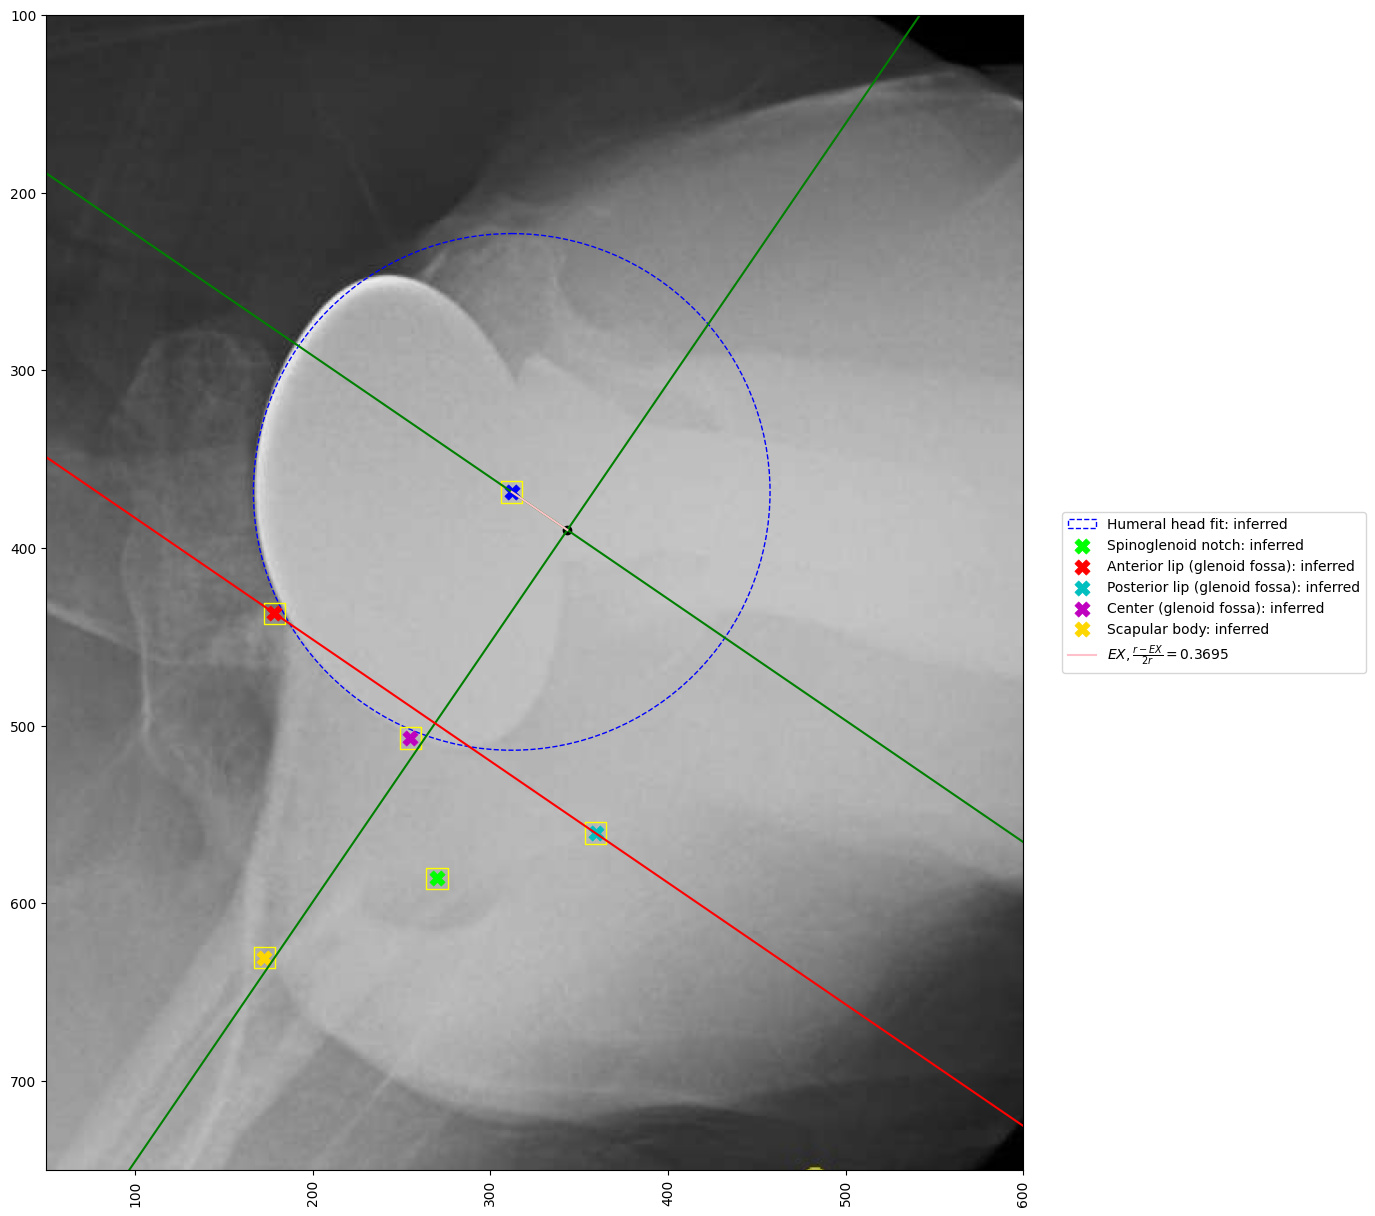

In [141]:
# original size

import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize = (15, 15))

img = plt.imread("1014.postopAxillary.jpg")
plt.imshow(img)
# draw_pred_tr(tr_1014pa)
draw_pred_(pred)
# connect(pred, tr_1014pa)
# draw_retroversion(pred)
draw_centering(pred)
# Display the image

# Define grid parameters
grid_color = 'green'
pixel_interval = 10  # Interval between grid lines (adjust as needed)

# Add grid lines
# ax.xaxis.set_major_locator(ticker.MultipleLocator(pixel_interval))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(pixel_interval))
# ax.grid(which='major', color=grid_color, linestyle='-', linewidth=1)
plt.xticks(rotation = 90)
plt.xlim(50, 600)
plt.ylim(750, 100)

plt.show();

## XML dump

In [45]:
import xml.etree.ElementTree as ET

In [37]:
tree = ET.parse("annotations.xml")
root = tree.getroot()

In [48]:
for child in root:
    if child.tag!= "image":
        continue
    print("Tag: {0} text: {1}".format(child.tag, child.attrib))

    for landmark in child:
        print(landmark.tag, landmark.attrib)
    break

Tag: image text: {'id': '600', 'name': 'LD828-1.png', 'width': '646', 'height': '758'}
ellipse {'label': 'Circle fit to humeral articular surface', 'source': 'manual', 'occluded': '0', 'cx': '206.95', 'cy': '280.12', 'rx': '110.05', 'ry': '110.32', 'z_order': '0'}
points {'label': 'Posterior lip of glenoid fossa', 'source': 'manual', 'occluded': '0', 'points': '217.85,410.80', 'z_order': '0'}
ellipse {'label': 'Spinoglenoid notch', 'source': 'manual', 'occluded': '0', 'cx': '154.92', 'cy': '466.18', 'rx': '9.42', 'ry': '9.42', 'z_order': '0'}
points {'label': 'Scapular body point', 'source': 'manual', 'occluded': '0', 'points': '97.50,521.80', 'z_order': '0'}
points {'label': 'Center of glenoid fossa', 'source': 'manual', 'occluded': '0', 'points': '151.52,394.22', 'z_order': '0'}
points {'label': 'Anterior lip of glenoid fossa', 'source': 'manual', 'occluded': '0', 'points': '102.53,362.56', 'z_order': '0'}


In [92]:
target_tree = ET.parse("annotations_target.xml")
target_root = target_tree.getroot()


for child in target_root:
    if child.tag!= "image":
        continue    
    img_name = child.attrib["name"].split("/")[-1]
    try:
        img_map = mapping[img_name]
    except:
        print(f"error in mapping file name: {img_name}")
        continue   

    # humeral head
    landmark = ET.SubElement(child, "ellipse")
    landmark.set("label",  'Circle fit to humeral articular surface')
    landmark.set("source", "manual")
    landmark.set("occluded", "0")
    landmark.set("cx", f"{img_map[0]}")
    landmark.set("cy", f"{img_map[1]}")
    landmark.set("rx", f"{img_map[2]}")
    landmark.set("ry", f"{img_map[2]}")

    landmark.set("z_order", "0")

    # notch
    landmark = ET.SubElement(child, "ellipse")
    landmark.set("label",  'Spinoglenoid notch')
    landmark.set("source", "manual")
    landmark.set("occluded", "0")
    landmark.set("cx", f"{img_map[3]}")
    landmark.set("cy", f"{img_map[4]}")
    landmark.set("rx", "2")
    landmark.set("ry", "2")
    landmark.set("z_order", "0")

    #apcs
    landmark = ET.SubElement(child, "points")
    landmark.set("label", "Anterior lip of glenoid fossa")
    landmark.set("source", "manual")
    landmark.set("occluded", "0")
    landmark.set("points", f"{img_map[5]},{img_map[6]}")
    landmark.set("z_order", "0")



    # p 
    landmark = ET.SubElement(child, "points")
    landmark.set("label", "Posterior lip of glenoid fossa")
    landmark.set("source", "manual")
    landmark.set("occluded", "0")
    landmark.set("points", f"{img_map[7]},{img_map[8]}")
    landmark.set("z_order", "0")

    # c
    landmark = ET.SubElement(child, "points")
    landmark.set("label", "Center of glenoid fossa")
    landmark.set("source", "manual")
    landmark.set("occluded", "0")
    landmark.set("points", f"{img_map[9]},{img_map[10]}")
    landmark.set("z_order", "0")

    # s
    landmark = ET.SubElement(child, "points")
    landmark.set("label", "Scapular body point")
    landmark.set("source", "manual")
    landmark.set("occluded", "0")
    landmark.set("points", f"{img_map[11]},{img_map[12]}")
    landmark.set("z_order", "0")



# child = ET.SubElement(root_node, "user")
# child.set("username","srquery")
# group  = ET.SubElement(child,"group")
# group.text = "fresher"
# tree = ET.ElementTree(root_node)
# tree.write("users.xml")

In [91]:
target_tree.write("test.xml")